In [1]:
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 


# Chapter 14: ResNets

In [3]:
def get_data(url, presize, resize):
  path = untar_data(url)
  db = DataBlock(
      blocks=(ImageBlock, CategoryBlock),
      get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y=parent_label,
      item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=.5, size=resize),
                  Normalize.from_stats(*imagenet_stats)]
  )

  return db.dataloaders(path, bs=128)

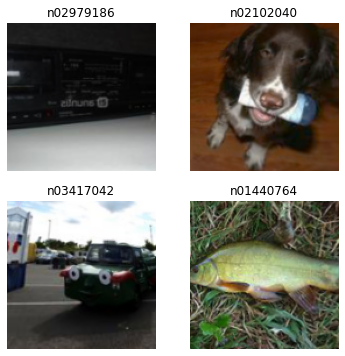

In [4]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

In [6]:
def block(n_in, n_out): return ConvLayer(n_in, n_out, stride=2)

def get_model():
  return nn.Sequential(
      block(3,16),
      block(16, 32),
      block(32, 64),
      block(64, 128),
      block(128, 256),
      nn.AdaptiveAvgPool2d(1),
      Flatten(),
      nn.Linear(256, dls.c)
  )

In [9]:
def get_learner(model):
  return Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [10]:
learn = get_learner(get_model())

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.00363078061491251)

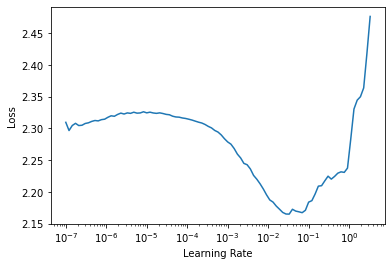

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.865053,1.757449,0.392357,00:23
1,1.517517,1.475488,0.535287,00:22
2,1.292295,1.170907,0.619873,00:22
3,1.134360,1.057212,0.661147,00:22
4,1.054039,1.085881,0.656051,00:22
